## Import Relevant Packages

In [221]:
import torch
from torch import nn
from collections import OrderedDict
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch_model_manager import TorchModelManager
import copy

## I. Auto-Encoders with Default Loss Function

In [314]:
class Net(nn.Module):
    def __init__(self, input_dim, layers):
        super(Net, self).__init__()
        self.layers = self.create_layers(input_dim, layers)

    def create_layers(self, input_dim, layers):
        layer_list = []
        prev_dim = input_dim
        for idx, layer_dim in enumerate(layers):
            layer_list.append((f'fc{idx}', nn.Linear(prev_dim, layer_dim)))

            prev_dim = layer_dim
        return nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        layers = []
        for layer in self.layers:
            x = layer(x)
            layers.append(x)
        return x, layers
        

In [435]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, layers=[64, 32, 16]):
        super(AutoEncoder, self).__init__()
        assert all(x>=y for x, y in zip(layers, layers[1:])), "Layers must be sorted in decreasing order"

        self.encoder = Net(input_dim, layers)

        self.decoder = Net(layers[-1], layers[-2::-1]+[input_dim])

    def forward(self, x):
        x, enc_layers = self.encoder(x)
        x, dec_layers = self.decoder(x)
        return x, enc_layers, dec_layers

In [443]:
x = torch.linspace(0, 5, 128)
vector = torch.exp(x)

layers_dim = [64, 32, 16, 8]
input_dim = 128
model = AutoEncoder(input_dim, layers_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

epochs = 1000000
for i in range(epochs):
    optimizer.zero_grad()
    output, enc_layers, dec_layers = model(vector)

    loss = criterion(output, vector)
    loss.backward()
    optimizer.step()
    print(f'----------------------- Epoch {i}/{epochs} -----------------------')
    print(f'Loss: {loss.item()}')
    for idx in range(len(layers_dim)-1):

        print(f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')
    if loss < 1e-7:
        break



----------------------- Epoch 0/1000000 -----------------------
Loss: 2275.29541015625
Loss 64: 987.3370361328125
Loss 32: 352.01824951171875
Loss 16: 123.81573486328125
----------------------- Epoch 1/1000000 -----------------------
Loss: 2275.252685546875
Loss 64: 987.2923583984375
Loss 32: 351.9884033203125
Loss 16: 123.9022216796875
----------------------- Epoch 2/1000000 -----------------------
Loss: 2275.210205078125
Loss 64: 987.2481079101562
Loss 32: 351.9591064453125
Loss 16: 123.98927307128906
----------------------- Epoch 3/1000000 -----------------------
Loss: 2275.167724609375
Loss 64: 987.2042236328125
Loss 32: 351.9302978515625
Loss 16: 124.07681274414062
----------------------- Epoch 4/1000000 -----------------------
Loss: 2275.125
Loss 64: 987.1607666015625
Loss 32: 351.90185546875
Loss 16: 124.16490173339844
----------------------- Epoch 5/1000000 -----------------------
Loss: 2275.08251953125
Loss 64: 987.1178588867188
Loss 32: 351.8738708496094
Loss 16: 124.25354003

In [444]:
def compare_input_output(input, output, title):
    # Create an array of indices
    indices = np.arange(len(output))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(indices, input, label='Input')
    plt.plot(indices, output, label='Output')
    plt.xlabel('Index')
    plt.ylabel('Output')
    plt.title(title)
    plt.legend()
    plt.show()

### Compare the Output of the Final Layer

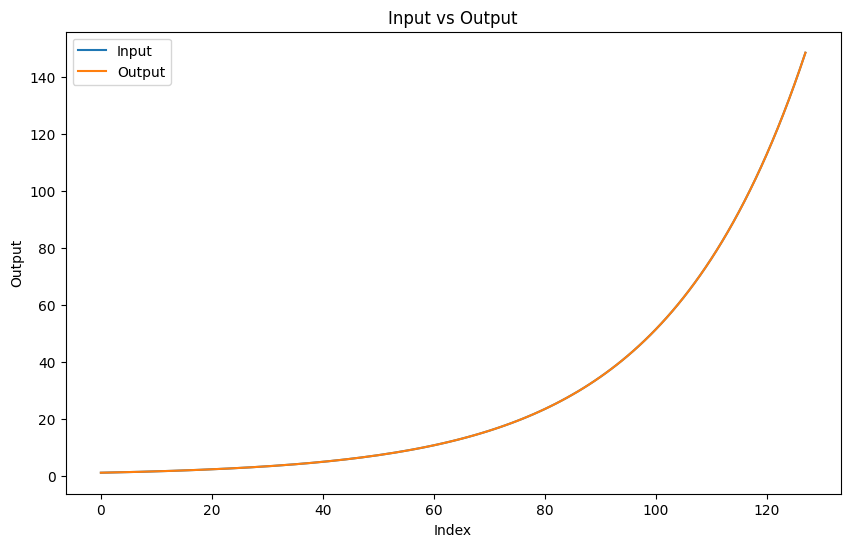

In [445]:
# compare_input_output(enc_layers[1].detach().numpy(), dec_layers[-3].detach().numpy())
compare_input_output(vector, model(vector)[0].detach(), title='Input vs Output')

### Compare the Outputs of Intermediate Layers

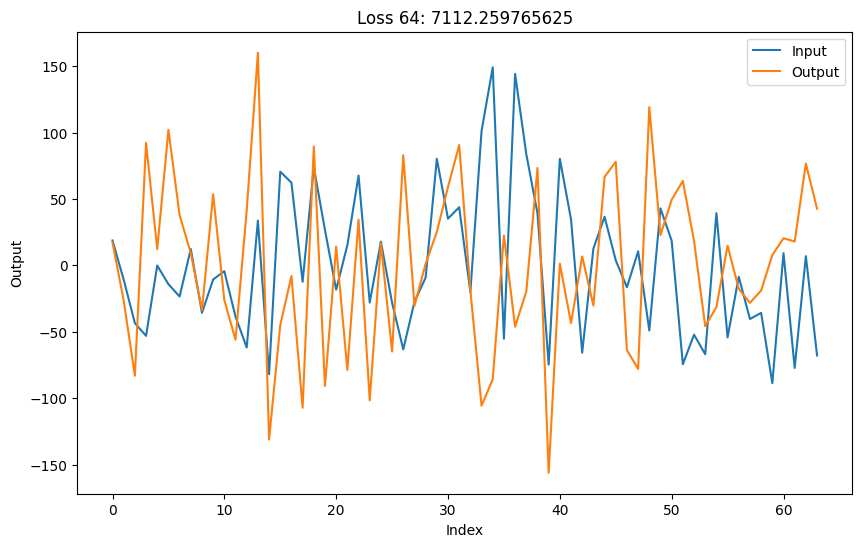

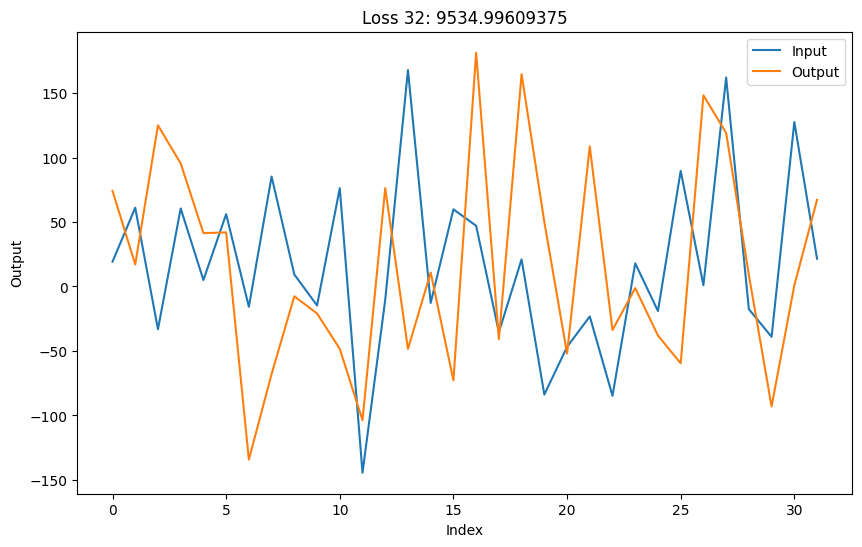

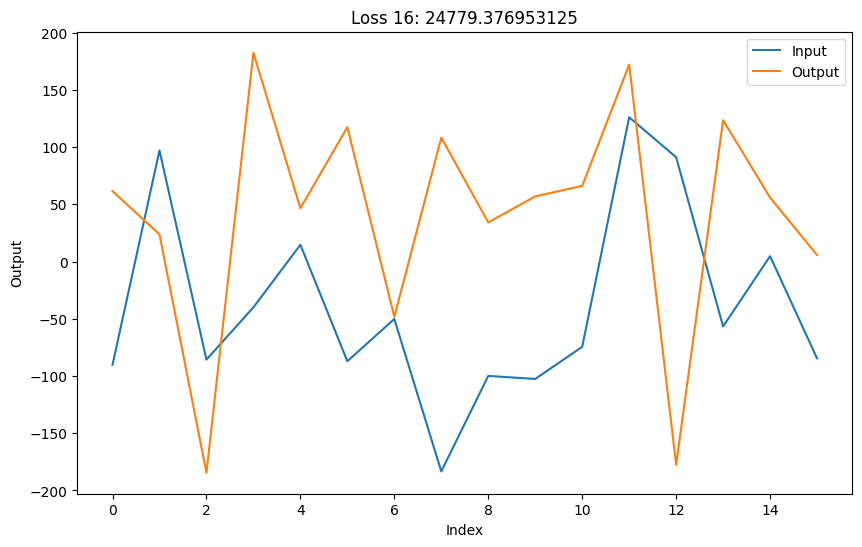

In [446]:
for idx in range(len(layers_dim)-1):
    compare_input_output(enc_layers[idx].detach().numpy(), dec_layers[-idx-2].detach().numpy(), title=f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')

## II. Auto-Encoders with Modified Loss Function